# Spin qubit measurement software

Load packages

In [22]:
import sys, os, tempfile
import numpy as np
%matplotlib inline
%gui qt
import matplotlib.pyplot as plt
import qcodes
from qcodes import MatPlot, QtPlot
import qtt
from qtt.measurements.scans import scanjob_t

# set data directory
datadir = os.path.join(tempfile.tempdir, 'qdata')
qcodes.DataSet.default_io = qcodes.DiskIO(datadir)    

## Load your station

The model resembles the a 3-dot spin-qubit dot setup. The hardware consists of a virtual
keithley, IVVI racks and a virtual gates object.

In [5]:
import qtt.simulation.virtual_dot_array as virtual_dot

nr_dots = 2
station = virtual_dot.initialize(nr_dots=nr_dots)

keithley1 = station.keithley1
keithley3 = station.keithley3

# virtual gates for the model
gates = station.gates

initialize: create virtualdot


## Setup measurement windows

We have
* a parameter viewer
* a lot plotting window

In [8]:
pv = qtt.createParameterWidget([gates, ])
mwindows = qtt.gui.live_plotting.setupMeasurementWindows(station, create_parameter_widget=False)
plotQ = mwindows['plotwindow']   

## Read out instruments

In [9]:
print('gate P1: %.1f, amplitude: %f' % (gates.P1.get(),  keithley3.readnext()) )
snapshotdata = station.snapshot()

gate P1: 0.4, amplitude: 0.995789


## Simple 1D scan loop

We use the `scan1D` function. This function has `scanjob` as argument.

In [10]:
scanjob = scanjob_t({'sweepdata': dict({'param': 'P1', 'start': -500, 'end': 1, 'step': .8, 'wait_time': 1e-2}), 'minstrument': [keithley3.amplitude]})
data1d = qtt.measurements.scans.scan1D(station, scanjob, location=None, verbose=1)

scan1D: 0/627: time 0.5
scan1D: 130/627: time 2.0
scan1D: 256/627: time 3.5
scan1D: 387/627: time 5.0
scan1D: 517/627: time 6.5


## Analyse the scan

keithley3_amplitude
analyseGateSweep: pinch-off point -212.000, value 0.297


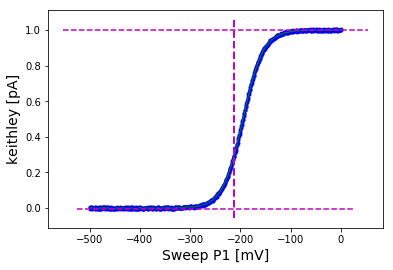

In [11]:
print( data1d.default_parameter_name() )
adata = qtt.algorithms.gatesweep.analyseGateSweep(data1d, fig=100)

##  Make a 2D scan

scan2D: 0/200: time 00:00:00 (~00:00:00 remaining): setting B0 to -500.000
scan2D: 57/200: time 00:00:02 (~00:00:05 remaining): setting B0 to -386.000
scan2D: 124/200: time 00:00:03 (~00:00:02 remaining): setting B0 to -252.000
scan2D: 195/200: time 00:00:05 (~00:00:00 remaining): setting B0 to -110.000


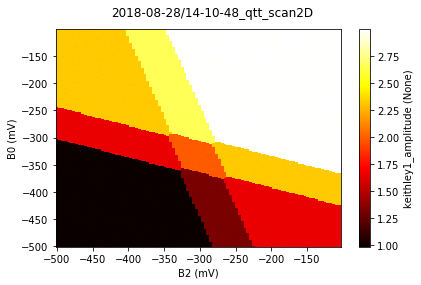

In [15]:
start=-500
scanjob = scanjob_t({'sweepdata': dict({'param': 'B2', 'start': start, 'end': start+400, 'step': 4.}), 'minstrument': ['keithley1.amplitude'], 'wait_time': 0.})
scanjob['stepdata'] = dict({'param': 'B0', 'start': start, 'end': start+400, 'step': 2.})
data = qtt.measurements.scans.scan2D(station, scanjob, liveplotwindow=plotQ)

_=qcodes.MatPlot(data.default_parameter_array())

## More analysis

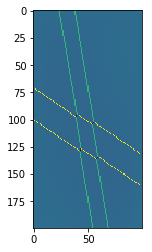

In [23]:
from qtt.utilities.imagetools import cleanSensingImage
im, tr = qtt.data.dataset2image(data)

imx=cleanSensingImage(im)
plt.imshow(imx)
#pt, resultsfine = qtt.legacy.analyse2dot(data, fig=300, efig=400, istep=1, verbose=2)

## Send data to powerpoint

We can copy data from a dataset to Powerpoint using `qtt.tools.addPPT_dataset(dataset)`.

In [25]:
_=qtt.utilities.tools.addPPT_dataset(data, verbose=1)    

could not open active Powerpoint presentation, opening blank presentation
addPPTslide: presentation name: Presentation1, adding slide 1


## Show the recorded data

In [26]:
logviewer = qtt.gui.dataviewer.DataViewer(datadir=datadir, verbose=1)

findfilesR: C:\Users\EENDEB~1\AppData\Local\Temp\qdata: 0.0%
findfilesR: C:\Users\EENDEB~1\AppData\Local\Temp\qdata: 43.6%
findfilesR: C:\Users\EENDEB~1\AppData\Local\Temp\qdata: 23.1%
findfilesR: C:\Users\EENDEB~1\AppData\Local\Temp\qdata: 76.7%
DataViewer: found 3286 files
